# Part I: NLP Basics
## Task: Sentiment analysis of movie reviews

In this task, problem at hand is to classify movie reviews as *positive* or *negative* using the text of the review. 
It is an example of a binary classification, a fundamental and widely applicable kind of machine learning problem. 

A widely-used dataset for this task is the [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb). 
It contains 50,000 movie reviews from IMDB, and preprocessed into
25,000 reviews for training and 25,000 reviews for testing. 
Notice that both sets are balanced, which means that there are equal numbers of items in both classes.  

First use a high-level framework for deep learning, [Keras](https://www.tensorflow.org/guide/keras), as the tool to build a model for this task. 
Keras helps us to leverage powerful backend toolkits such as Theano and [TensorFlow](https://www.tensorflow.org/).

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, CuDNNLSTM
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling1D
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

print(tf.__version__)

1.10.0


## Download the IMDB dataset

The IMDB dataset is conviently preprocessed by others and can be easily obtained using Keras. 
The reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary. The dictionary is also pre-built. 

Keras contains the following helper function that downloads the IMDB dataset to local machine.

```python
def load_data(path='imdb.npz', num_words=None, skip_top=0, maxlen=None, seed=113,
              start_char=1, oov_char=2, index_from=3, **kwargs):
```

For now, we will set vocabulary size to 10,000 words.

In [2]:
vocab_size = 10000
(train_data, train_labels), (test_data, test_labels) = \
       keras.datasets.imdb.load_data(num_words=vocab_size)

17465344/17464789 [==============================] - 2s 0us/step


The argument `num_words=vocab_size` keeps the top 10,000 most frequently occurring words in the training data. 
Other rare words are replaced by `oov_char` to keep the size of the model manageable. 

Keras also comes with a pre-built dictionary of mapping words to its ID. However, it does not match the preprocessed word IDs. We need to add special words into this dictionary. `<PAD>` `<SOS>` `<UNK>` are added to match the settings `start_char=1, oov_char=2, index_from=3` in `load_data()`.

It is common in NLP to add these special words in the dictionary. We want to add the *PADDING* symbol `<PAD>`, *Start-of-sentence* symbol `<SOS>`, and *Unknown* symbol `<UNK>`.

In [6]:
# A dictionary mapping words --> integer index
word_index = keras.datasets.imdb.get_word_index()

# Shift word index by 3 because we want to add special words
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0  # padding
word_index["<SOS>"] = 1  # start of sequence
word_index["<UNK>"] = 2  # unknown (out of the top 10,000 most frequent words)

1646592/1641221 [==============================] - 0s 0us/step


For our convenience, we will create a helper function to convert integer IDs back to words. It is easier to find errors that way

In [10]:
# Build another dictionary of mapping integer --> words 
reverse_word_index = dict([(v, k) for (k, v) in word_index.items()])

# Create a helper function to convert the integer to words
# also limit max length
def decode_review(text):
    words = [reverse_word_index.get(i, "<UNK>") for i in text]
    fixed_width_string = []
    # limit max length = 10
    for w_pos in range(len(words)):
        fixed_width_string.append(words[w_pos])
        if (w_pos+1) % 10 == 0:
            fixed_width_string.append('\n')
    return(' '.join(fixed_width_string))

## Always check the content

### Confirm the correctness of preprocessing, because things can go wrong in so many ways.

Each input should contain a list of integers representing the words of the movie review, and output should be an integer of 0 or 1. We use 0 to represent a negative review and 1 positive. First we want to make sure the number of reviews and labels are equal.

In [11]:
print("Training data: {} reviews, {} labels".format(len(train_data), len(train_labels)))

Training data: 25000 reviews, 25000 labels


The words should be converted to integers, where each integer represents a specific word in a dictionary. Here's what the first review looks like:

In [12]:
print("Word IDs")
print(train_data[0])
print("Label")
print(train_labels[0])

Word IDs
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
Label
1


Movie reviews may be of different lengths. We can see by examining a few of them. 

Since inputs must be the same length, we'll need to resolve this later.

In [15]:
len(train_data[0]), len(train_data[1])

(218, 189)

We can use the `decode_review` function to display the text for the first review, and also check for any error.

In [16]:
print(decode_review(train_data[0]))

<SOS> this film was just brilliant casting location scenery story 
 direction everyone's really suited the part they played and you 
 could just imagine being there robert <UNK> is an amazing 
 actor and now the same being director <UNK> father came 
 from the same scottish island as myself so i loved 
 the fact there was a real connection with this film 
 the witty remarks throughout the film were great it was 
 just brilliant so much that i bought the film as 
 soon as it was released for <UNK> and would recommend 
 it to everyone to watch and the fly fishing was 
 amazing really cried at the end it was so sad 
 and you know what they say if you cry at 
 a film it must have been good and this definitely 
 was also <UNK> to the two little boy's that played 
 the <UNK> of norman and paul they were just brilliant 
 children are often left out of the <UNK> list i 
 think because the stars that play them all grown up 
 are such a big profile for the whole film but 
 these children are ama

If we did **not** add special words in word_index, we will see that the reviews don't make any sense when using `decode_review`.  

## Prepare the data for input

Since the inputs must be of the same length, we will use the helper function `pad_sequences` in Keras to unify the lengths.

Important options:
* Max length = 100
* The argument `padding='pre'` means that we are padding the beginning of a sentence.
* If we set `maxlen=None`, Keras will automatically pad to __longest__ sequence in the dataset. 
* `truncating='pre'` indicates that the truncating will happen from the beginning of the review, so we are keeping the __last__ `maxlen=100` words
* `value` means what to pad when we have missing

In [17]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='pre',
                                                        truncating='pre',
                                                        maxlen=100)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='pre',
                                                       truncating='pre',
                                                       maxlen=100)

Let's look at the length of the examples now:

In [18]:
len(train_data[0]), len(train_data[1])

(100, 100)

And inspect the first review:

In [19]:
print(train_data[0])

[1415   33    6   22   12  215   28   77   52    5   14  407   16   82
    2    8    4  107  117 5952   15  256    4    2    7 3766    5  723
   36   71   43  530  476   26  400  317   46    7    4    2 1029   13
  104   88    4  381   15  297   98   32 2071   56   26  141    6  194
 7486   18    4  226   22   21  134  476   26  480    5  144   30 5535
   18   51   36   28  224   92   25  104    4  226   65   16   38 1334
   88   12   16  283    5   16 4472  113  103   32   15   16 5345   19
  178   32]


Compare the review now vs. the original above.

In [20]:
print(decode_review(train_data[0]))

cry at a film it must have been good and 
 this definitely was also <UNK> to the two little boy's 
 that played the <UNK> of norman and paul they were 
 just brilliant children are often left out of the <UNK> 
 list i think because the stars that play them all 
 grown up are such a big profile for the whole 
 film but these children are amazing and should be praised 
 for what they have done don't you think the whole 
 story was so lovely because it was true and was 
 someone's life after all that was shared with us all 



We can see that the review has been cut from the beginning, because we set `truncating='pre'` in `pad_sequences`.

For shorter reviews, we can see that it has been padded from the beginning as in the next example.

In [21]:
print(decode_review(train_data[5]))

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <SOS> begins better 
 than it ends funny that the russian submarine crew <UNK> 
 all other actors it's like those scenes where documentary shots 
 br br spoiler part the message <UNK> was contrary to 
 the whole story it just does not <UNK> br br 



## Create a validation set

In [22]:
x_val = train_data[:1000]
partial_x_train = train_data[1000:10000]

y_val = train_labels[:1000]
partial_y_train = train_labels[1000:10000]

## Build the model

Keras can help us build a model quickly. The neural network is created by adding layers. However, questions are :
* How many layers?
* How many hidden units to use for each layer?

Let's build a simple model for the sentiment analysis problem!

In [23]:
model = keras.Sequential()
# Embedding layer maps each of the 10000 words to 100-d embeddings
model.add(Embedding(vocab_size, 100))
# Average the embeddings
model.add(GlobalAveragePooling1D())
# 1 Fully-connected layer
model.add(Dense(16, activation=tf.nn.relu))
# 2 Fully-connected layer
model.add(Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,001,633
Trainable params: 1,001,633
Non-trainable params: 0
_________________________________________________________________


### Layers
In this model, the layers are linked sequentially, i.e., the output of the previous layer is sent to the next layer only.

The first layer is an `Embedding` layer. This layer takes a sequence of word IDs (integer) and looks up an embedding matrix for a vector that represents that ID. **These vectors are learned as the model trains**. Note that, since this layer converts the 2D input of shape `(batch, sequence_len)` to `(batch, sequence_len, embedding_size)`.

---

The next layer, `GlobalAveragePooling1D` layer, calculates an average of the **second dimension**. So a batch of sequences of embeddings with shape `(batch, sequence_len, embedding_size)` will be averaged to a shape `(batch, embedding_size)`. 

---

The last two layers are fully-connected (`Dense`) layer with 16  and 1 hidden unit(s).
First fully-connected layer can be thought of as a feature reduction.
The final layer is applying the `sigmoid` activation function, which has an output value between 0 and 1, to act as a probability or confidence level.

### Hidden units

The above model has several intermediate or "hidden" layers, between the input and output. The number of "units" (or neurons) is the dimension of the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.

If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. This is called *overfitting*, and we'll explore it later.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a **binary** classification problem and the model outputs of a probability (a single-unit layer with a `sigmoid` activation function), we'll use the `binary_crossentropy` loss function. 

This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions. 


---


If you are handling a classification problem with more that two classes, you will need to set the final layer to have the same number of units as your classes. The model then outputs probabilities of each class (using a `softmax` activation function). Then, you will need to use the `categorical_crossentropy` loss function. 

When you are dealing with regression problems (say, to predict the price of a house), you  will need to use other loss functions such as `mean_squared_error`.


---


The design of Keras requires us to configure the loss and optimizer of the model together.

In [24]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Train the model

Train the model for *n* epochs in mini-batches of samples. Recall that this is *n* iterations over all samples in the training data. While training, monitor the model's loss and accuracy on the validation set:

In [44]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=100,
                    validation_data=(x_val, y_val))

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 125us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.8637 - val_acc: 0.8120
Epoch 2/10
9000/9000 [==============================] - 1s 125us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.8744 - val_acc: 0.8100
Epoch 3/10
9000/9000 [==============================] - 1s 125us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.8931 - val_acc: 0.8110
Epoch 4/10
9000/9000 [==============================] - 1s 131us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.9005 - val_acc: 0.8120
Epoch 5/10
9000/9000 [==============================] - 1s 127us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.9056 - val_acc: 0.8090
Epoch 6/10
9000/9000 [==============================] - 1s 127us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.9243 - val_acc: 0.8110
Epoch 7/10
9000/9000 [==============================] - 1s 128us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.9339 - val_acc: 0.8120


In [40]:
history

## Evaluate the model

And let's see how the model performs on the test set. Two values will be returned when calling `.evaluate` function, **loss** (we defined it as binary cross entropy) and **accuracy**.  Keras will report whatever we used in the `model.compile` function as the evaluation metrics.


In [45]:
results = model.evaluate(test_data, test_labels)
print(results)

25000/25000 [==============================] - 0s 17us/step
[0.9897150010061264, 0.81148]


This fairly naive approach achieves an accuracy of 83%.

## Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training. There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy. We will write a helper function to plot loss and accuracy of each epoch.

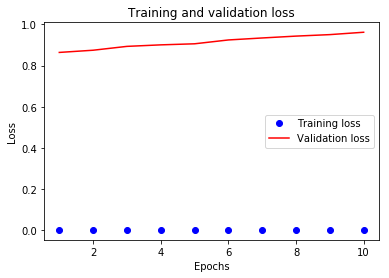

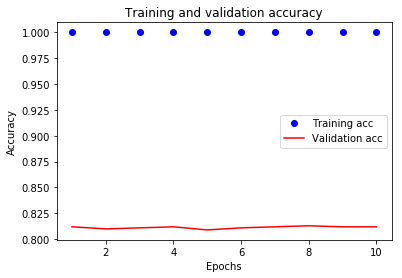

In [46]:
def plot_hist(history):
    history_dict = history.history
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    # plot for loss
    plt.clf()   # clear figure
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # r is for "red solid line"
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # plot for accuracy
    plt.clf()   # clear figure
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_hist(history)

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected because we designed the model to optimize for this goal.

However, the loss and accuracy for validation data is usually different from the training data. They usually peak after some epochs. 

Recall that we have talked about **overfitting**: the model performs much better on the training data than it does on new data. 
After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

We could prevent overfitting by simply stopping the training after some epochs by observing these plots. Also,  we could apply a simple method that uses `Dropout`.

## Deal with overfitting
A very straightforward method is to insert `Dropout` layers in between our previous layers.  

**Important**: `Dropout(rate)` rate is a float between 0 and 1 that indicates the fraction of the input units to **drop**. 

However, in `tensorflow`, the dropout layers take an argument of `keep_prob` which indicates the fraction to **keep**.

In [47]:
# Clear previous model
model = None
K.clear_session()
model = keras.Sequential()
# Embedding layer maps each of the 10000 words to 100-d embeddings
model.add(Embedding(vocab_size, 100))
# Average the embeddings
model.add(GlobalAveragePooling1D())
# 1 Fully-connected layer
model.add(Dense(16, activation=tf.nn.relu))

# Dropout layer
model.add(Dropout(0.5))

# 2 Fully-connected layer
model.add(Dense(1, activation=tf.nn.sigmoid))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,001,633
Trainable params: 1,001,633
Non-trainable params: 0
_________________________________________________________________


Train on 9000 samples, validate on 1000 samples
Epoch 1/12
9000/9000 [==============================] - 1s 166us/step - loss: 0.7234 - acc: 0.5078 - val_loss: 0.6895 - val_acc: 0.5360
Epoch 2/12
9000/9000 [==============================] - 1s 125us/step - loss: 0.6844 - acc: 0.5644 - val_loss: 0.6799 - val_acc: 0.5750
Epoch 3/12
9000/9000 [==============================] - 1s 127us/step - loss: 0.6740 - acc: 0.6016 - val_loss: 0.6664 - val_acc: 0.7640
Epoch 4/12
9000/9000 [==============================] - 1s 134us/step - loss: 0.6580 - acc: 0.6323 - val_loss: 0.6476 - val_acc: 0.7690
Epoch 5/12
9000/9000 [==============================] - 1s 127us/step - loss: 0.6362 - acc: 0.6420 - val_loss: 0.6206 - val_acc: 0.7910
Epoch 6/12
9000/9000 [==============================] - 1s 131us/step - loss: 0.6056 - acc: 0.6736 - val_loss: 0.5850 - val_acc: 0.8060
Epoch 7/12
9000/9000 [==============================] - 1s 128us/step - loss: 0.5691 - acc: 0.7076 - val_loss: 0.5464 - val_acc: 0.8150


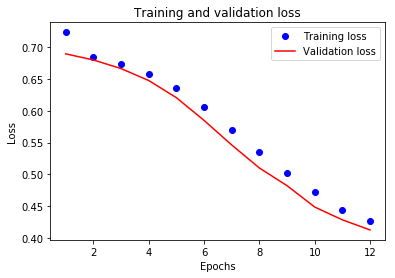

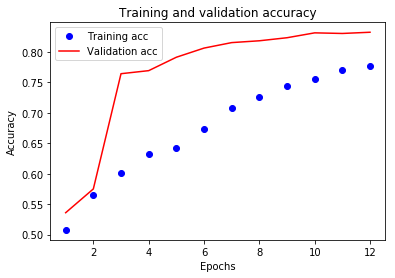

In [48]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=12,
                    batch_size=100,
                    validation_data=(x_val, y_val))
plot_hist(history)

Compare the two plots from two models, it seems that `Dropout` is effective at reducing overfitting!


Also remember that when applying dropout, we usually need to train for more epochs.

In [49]:
results = model.evaluate(test_data, test_labels)
print(results)

25000/25000 [==============================] - 0s 17us/step
[0.41767537291526796, 0.83388]


## Build a recurrent model

Try change to a recurrent model in Keras. Replace `Dense` with `LSTM`.


---


Specifically, some parameters can be set for the LSTM cell.

```python
LSTM(hidden_units, dropout=0.0, recurrent_dropout=0.0)
```

The first `dropout` refers to the dropping of input features, and `recurrent_dropout` refers to the dropping of the previous output.

![dropout_difference](https://drive.google.com/uc?export=view&id=1kiiV6BvPalvGnA6zg3LioDHOMs44TBrr)

In [52]:
model = None
K.clear_session()
model = keras.Sequential()
model.add(Embedding(vocab_size, 100))

# Add a recurrent layer
# model.add(LSTM(32, dropout=0.5, recurrent_dropout=0.5))
## or CuDNNLSTM
model.add(LSTM(32, dropout=0.5, recurrent_dropout=0.5))
##

model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________


Again, we build the model and train for some epochs. Observe the change of loss and accuracy compared with the previous model.

**Note**: due to speed issues we will train for 4 epochs when using recurrent models. You can try changing that later! Also, you can use `CuDNNLSTM` which is the latest LSTM version in tensorflow that is optimized for GPU. However, it does **not** support dropout itself.

Train on 9000 samples, validate on 1000 samples
Epoch 1/8
9000/9000 [==============================] - 9s 1ms/step - loss: 0.7009 - acc: 0.5102 - val_loss: 0.6923 - val_acc: 0.5220
Epoch 2/8
9000/9000 [==============================] - 11s 1ms/step - loss: 0.6913 - acc: 0.5249 - val_loss: 0.6892 - val_acc: 0.5520
Epoch 3/8
9000/9000 [==============================] - 10s 1ms/step - loss: 0.6837 - acc: 0.5592 - val_loss: 0.6867 - val_acc: 0.5430
Epoch 4/8
9000/9000 [==============================] - 10s 1ms/step - loss: 0.6732 - acc: 0.5800 - val_loss: 0.6700 - val_acc: 0.5870
Epoch 5/8
9000/9000 [==============================] - 10s 1ms/step - loss: 0.6571 - acc: 0.6112 - val_loss: 0.6544 - val_acc: 0.6090
Epoch 6/8
9000/9000 [==============================] - 10s 1ms/step - loss: 0.6300 - acc: 0.6410 - val_loss: 0.6318 - val_acc: 0.6370
Epoch 7/8
9000/9000 [==============================] - 10s 1ms/step - loss: 0.6027 - acc: 0.6651 - val_loss: 0.6250 - val_acc: 0.6420
Epoch 8/8
9000/

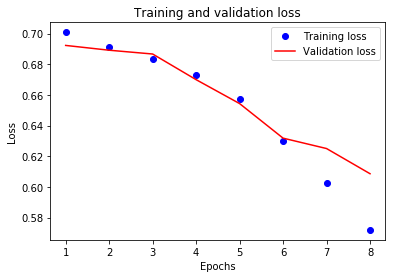

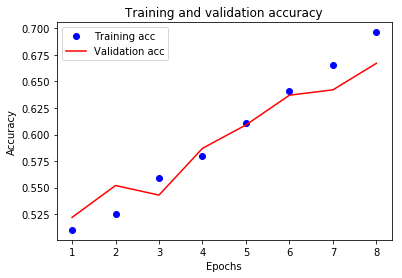

In [53]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.train.AdamOptimizer(),
              metrics=['accuracy'])
history = model.fit(partial_x_train, \
                    partial_y_train, \
                    epochs=8, \
                    batch_size=100, \
                    validation_data=(x_val, y_val))

plot_hist(history)

We can see a very large decrease in speed. (**55us/step** vs. **3ms/step**, which is about **55** times slower)

And evaluate on the test set.

In [54]:
results = model.evaluate(test_data, test_labels)
print(results)

25000/25000 [==============================] - 11s 449us/step
[0.6198389498138428, 0.65372]


### Improvements to a recurrent model
First, we will try to make it *deeper* by adding more LSTMs. 

**We must change the previous layers!!**

By default, a recurrent cell only returns the **last** output. But for multiple layers of recurrent cells, we need the **entire** output. 

So, we have to set `return_sequences=True` for all recurrent layers except the last one.

In [55]:
model = None
K.clear_session()
model = keras.Sequential()
model.add(Embedding(vocab_size, 32))

model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32, return_sequences=False))

model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 336,673
Trainable params: 336,673
Non-trainable params: 0
_________________________________________________________________


Train on 9000 samples, validate on 1000 samples
Epoch 1/4
9000/9000 [==============================] - 14s 2ms/step - loss: 0.6919 - acc: 0.5190 - val_loss: 0.6828 - val_acc: 0.5230
Epoch 2/4
9000/9000 [==============================] - 13s 1ms/step - loss: 0.6048 - acc: 0.6757 - val_loss: 0.5069 - val_acc: 0.7700
Epoch 3/4
9000/9000 [==============================] - 13s 1ms/step - loss: 0.4301 - acc: 0.8084 - val_loss: 0.4654 - val_acc: 0.7790
Epoch 4/4
9000/9000 [==============================] - 12s 1ms/step - loss: 0.3310 - acc: 0.8629 - val_loss: 0.4627 - val_acc: 0.7980


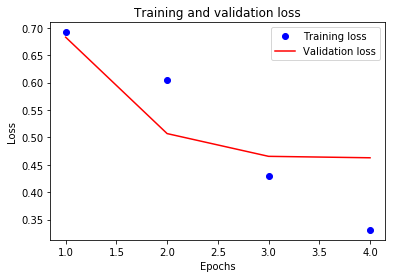

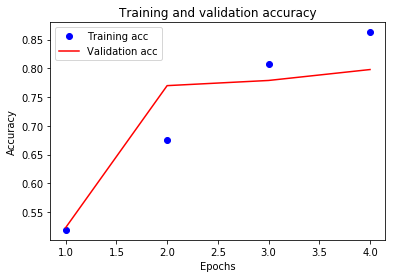

In [56]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=4,
                    batch_size=100,
                    validation_data=(x_val, y_val))
plot_hist(history)

Try using *bi-directional* RNN. Wrap LSTM cell in `Bidirectional()`.


In [57]:
model = None
K.clear_session()
model = keras.Sequential()
model.add(Embedding(vocab_size, 32))

model.add(Bidirectional(LSTM(32, return_sequences=False)))

model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 336,705
Trainable params: 336,705
Non-trainable params: 0
_________________________________________________________________


Train on 9000 samples, validate on 1000 samples
Epoch 1/4
9000/9000 [==============================] - 10s 1ms/step - loss: 0.6928 - acc: 0.5190 - val_loss: 0.6863 - val_acc: 0.5560
Epoch 2/4
9000/9000 [==============================] - 10s 1ms/step - loss: 0.6579 - acc: 0.6076 - val_loss: 0.6169 - val_acc: 0.6510
Epoch 3/4
9000/9000 [==============================] - 10s 1ms/step - loss: 0.5179 - acc: 0.7426 - val_loss: 0.4855 - val_acc: 0.7770
Epoch 4/4
9000/9000 [==============================] - 10s 1ms/step - loss: 0.3952 - acc: 0.8247 - val_loss: 0.5486 - val_acc: 0.7320


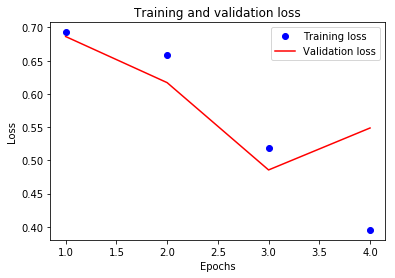

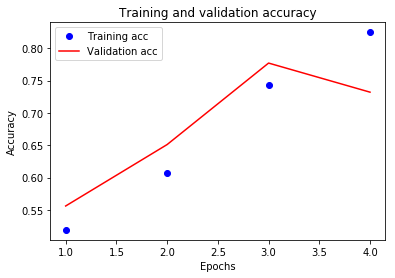

In [58]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=4,
                    batch_size=100,
                    validation_data=(x_val, y_val))
plot_hist(history)

Combine deep LSTM with bidirectional

In [59]:
model = None
K.clear_session()
model = keras.Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32, return_sequences=False)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 361,537
Trainable params: 361,537
Non-trainable params: 0
_________________________________________________________________


Train on 9000 samples, validate on 1000 samples
Epoch 1/4
9000/9000 [==============================] - 24s 3ms/step - loss: 0.6918 - acc: 0.5261 - val_loss: 0.6805 - val_acc: 0.5800
Epoch 2/4
9000/9000 [==============================] - 22s 2ms/step - loss: 0.6255 - acc: 0.6528 - val_loss: 0.5672 - val_acc: 0.7010
Epoch 3/4
9000/9000 [==============================] - 22s 2ms/step - loss: 0.4786 - acc: 0.7756 - val_loss: 0.4881 - val_acc: 0.7500
Epoch 4/4
9000/9000 [==============================] - 22s 2ms/step - loss: 0.3658 - acc: 0.8460 - val_loss: 0.4523 - val_acc: 0.7880


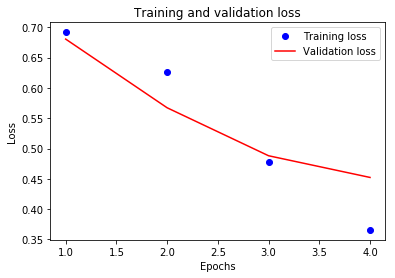

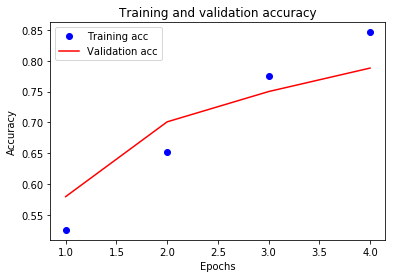

In [60]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=4,
                    batch_size=100,
                    validation_data=(x_val, y_val))
plot_hist(history)

We can see that it is even slower than our previous model (about 3 times slower), but the loss and accuracy are better than previous models.

## Pretrained embeddings
Try using **pretrained embeddings**.
Pretrained embeddings are not limited to recurrent models. They can be very useful in almost every NLP applications. 

Instead of randomly initialize the word embeddings, we can train them using a huge amout of (unlabeled) data in an unsupervised fashion.


---

We will use the [GloVe embeddings](http://nlp.stanford.edu/projects/glove/) to initialize our embedding weights. 
The file format is 
```
word1  0.xx -0.xx ... 
word2  0.yy 0.yy ...
```
Here, we read the entire file and see which of those words are in our dictionary. If we find one, we will set its embedding accordingly. Other words that are not found in the pretrained embeddings can be initialized as all zeros or very small numbers.

In [62]:
## Download pretrained GloVe embeddings from kaggle
# !kaggle datasets download -d terenceliu4444/glove6b100dtxt
# !unzip glove6b100dtxt.zip

## Randomize pretrained embeddings matrix with very small numbers
pretrained_embedding_matrix = (np.random.rand(vocab_size, 100) - 0.5) / 1e4
## Initialize embeddings matrix to all zeros
# pretrained_embedding_matrix = np.zeros((vocab_size, 100))
## Load pretrained embeddings
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        if word in word_index:
            embs = np.asarray(values[1:], dtype='float32')
            if word_index[word] >= vocab_size: continue
            pretrained_embedding_matrix[word_index[word]] = embs

/usr/bin/sh: kaggle: command not found
unzip:  cannot find or open glove6b100dtxt.zip, glove6b100dtxt.zip.zip or glove6b100dtxt.zip.ZIP.


FileNotFoundError: [Errno 2] No such file or directory: 'glove.6B.100d.txt'

`pretrained_embedding_matrix` now contains pre-trained embeddings and can be used to initialize the embedding layer.

An option is to set the embeddings to `trainable=False` which stops them from begin updated during training. 
However, this is not always useful as the pretrained embeddings may come from a **different dataset**. 

If you have a large amount of unlabeled data and a smaller labeled data, both from the same source, you can consider setting the `trainable=False` flag. This has an additional benefit of **reducing the number of parameters**, which in turn reduces the amount of training data that you need!

We can test the effect of pretrained embeddings on our very simple model first.

In [0]:
model = None
K.clear_session()
model = keras.Sequential()

# Embedding layer with pretrained embeddings
model.add(Embedding(vocab_size, 100, weights=[pretrained_embedding_matrix]))

model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation=tf.nn.relu))
model.add(Dense(1, activation=tf.nn.sigmoid))
model.summary()
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=8,
                    batch_size=100,
                    validation_data=(x_val, y_val))
plot_hist(history)

In [0]:
results = model.evaluate(test_data, test_labels)
print(results)

We can see that the model improved slightly from 83% to 84%. 

Next we will try it on the RNN.

In [0]:
model = None
K.clear_session()
model = keras.Sequential()
model.add(Embedding(vocab_size, 100, weights=[pretrained_embedding_matrix]))
model.add(CuDNNLSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=4,
                    batch_size=100,
                    validation_data=(x_val, y_val))
plot_hist(history)

Finally, we test its performance on the test set.

In [0]:
results = model.evaluate(test_data, test_labels)
print(results)